In [1]:
import bayesopt as bo
from bayesopt.utils import easy_meshgrid

In [2]:
from bayesopt import BayesOpt
from botorch.acquisition import ExpectedImprovement
from botorch.models import FixedNoiseGP, SingleTaskGP
from bayesopt.utils import stybtang
from botorch.test_functions import branin, hartmann6, eggholder
from botorch.test_functions import neg_branin, neg_hartmann6, neg_eggholder
import torch
import gpytorch
from gpytorch.kernels import ScaleKernel, MaternKernel, RBFKernel
from gpytorch.priors import SmoothedBoxPrior, GammaPrior
import matplotlib.pyplot as plt
import scipy
from fitting.optimizing import learn_projections

In [28]:
import imp
import gp_models
import botorch
import bayesopt
import rp
from bayesopt.utils import get_mixins, get_lengthscales, li_mixture_of_gaussians, li_rotated_mixture_of_gaussians, _mvnpdf
import numpy as np
imp.reload(botorch)
imp.reload(torch)
imp.reload(gp_models)
imp.reload(bayesopt)
BayesOpt = bayesopt.BayesOpt

In [120]:
def li_mixture_of_gaussians(x, dprime, v1, v2, v3):
    var = 0.01 * (dprime ** 0.1)
#     print(dprime)
#     print(var)
#     mvn = MultivariateNormal(v1, torch.eye(dprime)*var)
#     print(torch.exp(mvn.log_prob(x)))
    part1 = 0.1*_mvnpdf(x, v1, var)
#     print(part1)
    part2 = 0.1*_mvnpdf(x, v2, var)
#     print(part2)
    part3 = 0.8*_mvnpdf(x, v3, var)
#     print(part3)
    return torch.log(part1 + part2 + part3)


def li_rotated_mixture_of_gaussians(x, A, dprime=None, v1=None, v2=None, v3=None):
    n, D = x.shape
    x = x.to(torch.double)
    A = A.to(torch.double)
    if dprime is None:
        dprime = D/2
    M = int(D / dprime)
    if v1 is None:
        v1 = torch.ones(1, dprime, dtype=torch.double) / 2
    if v2 is None:
        v2 = torch.ones(1, dprime, dtype=torch.double) / 4
    if v3 is None:
        v3 = torch.ones(1, dprime, dtype=torch.double) / 4 * 3
    z = x.matmul(A.t())
    toreturn = torch.zeros(n, dtype=torch.double)
    for i in range(M):
        start = i*dprime
        end = (i+1)*dprime
        toreturn = toreturn + li_mixture_of_gaussians(z[:, start:end], dprime, v1, v2, v3)
    return toreturn.to(torch.float)

In [121]:
x = easy_meshgrid([100, 100], interior=False)
A = torch.tensor([[1., 0], [0, 1.]])
f = li_rotated_mixture_of_gaussians(x, A, dprime=2)

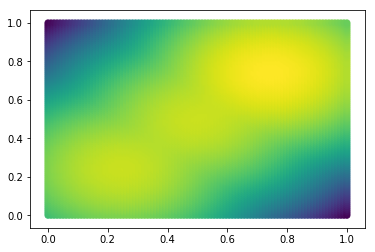

In [122]:
plt.scatter(x.numpy()[:, 0], x.numpy()[:, 1], c=f.numpy())

In [123]:
D = 50
A = torch.eye(D, dtype=torch.float) # + (torch.rand(D, D)/2-1/4)

In [124]:
def synth_obj_D50(x):
    return li_rotated_mixture_of_gaussians(x, A, dprime=25)

In [125]:
bounds = [(0, 1) for _ in range(D)]
def objective_function(x):
#     res = -embed_stybtang(x)
#     res = neg_eggholder(x)
#     res = -stybtang(x)
    res = synth_obj_D50(x)
#     print('Queried: {}'.format(res))
    return res
train_yvar = torch.tensor([0.01], dtype=torch.float)

In [126]:
k = 1
J = 20
projs = [rp.gen_rp(d, k) for _ in range(J)]
bs = [torch.zeros(k) for _ in range(J)]
def create_add_gp(trainX, trainY):
    model = FixedNoiseGP(trainX, trainY, train_yvar.expand_as(trainY)).to(trainX)
#     kernel = gp_models.StrictlyAdditiveKernel(d, MaternKernel, weighted=True, nu=2.5,
#                                               batch_shape=model._aug_batch_shape,
#                                               lengthscale_prior=GammaPrior(3., 6.),
#                                              outputscale_prior=GammaPrior(2.0, 0.15))

#     kernel = gp_models.PolynomialProjectionKernel(J, k, d, MaternKernel, projs, bs, learn_proj=False, weighted=True, 
#                                                  lengthscale_prior=GammaPrior(3., 6.0),
#                                                  outputscale_prior=GammaPrior(2.0, 0.15), nu=2.5)

#     kernels = [RBFKernel() for _ in range(20)]
#     joint_model = learn_projections(kernels, trainX, trainY, max_projections=20, post_fit=False)
#     kernel = 
#     kernel.initialize([.6, .7], [.2, .7])
#     kernel = ScaleKernel(kernel)
#     print(joint_model.covar_module)
#     model.covar_module = kernel
    return model

In [127]:
from IPython.display import clear_output

In [128]:
optimizers = []
n_repeats = 4

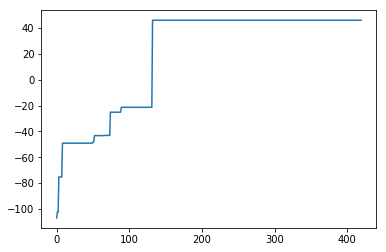

In [129]:
plt.plot(optimizer.best_true_y_path)

In [ ]:
for repeat in range(n_repeats):
    optimizer = BayesOpt(objective_function, bounds,
                         create_add_gp,
                         ExpectedImprovement, gp_optim_freq=4, initial_points=40,
                         from_scratch_freq=4, gp_optim_method='botorch_scipy')
    with gpytorch.settings.lazily_evaluate_kernels(True):
        optimizer.initialize()
    #     for _ in range(40):
        for i in range(960):
            n_errors = 0
#             print(i)
            if i % 20 == 0:
                print('iter={}, Best: {}'.format(i+40, optimizer.best_true_y.item()))
            while n_errors < 10:
                try:
                    optimizer.step()
                    break
                except Exception as e:
                    print(e)
                    n_errors += 1

        best_at_500 = optimizer.best_true_y_path[460]
        best_at_1000 = optimizer.best_true_y_path[960]
        clear_output()
        print('Best At 500={}, 1000={}'.format(best_at_500, best_at_1000))
    optimizers.append(optimizer)

iter=40, Best: -56.796627044677734
iter=60, Best: -36.77436828613281
iter=80, Best: -31.602725982666016
iter=100, Best: -31.602725982666016
iter=120, Best: -23.96578598022461
iter=140, Best: 42.810794830322266
iter=160, Best: 42.810794830322266
iter=180, Best: 42.810794830322266
iter=200, Best: 42.810794830322266
iter=220, Best: 42.810794830322266
iter=240, Best: 42.810794830322266
iter=260, Best: 42.810794830322266
iter=280, Best: 42.810794830322266
iter=300, Best: 42.810794830322266
iter=320, Best: 42.810794830322266
iter=340, Best: 42.810794830322266
iter=360, Best: 42.810794830322266
iter=380, Best: 42.810794830322266
iter=400, Best: 42.810794830322266
iter=420, Best: 42.810794830322266
iter=440, Best: 42.810794830322266
iter=460, Best: 42.810794830322266
iter=480, Best: 42.810794830322266
iter=500, Best: 42.810794830322266
iter=520, Best: 42.810794830322266
iter=540, Best: 42.810794830322266
iter=560, Best: 42.810794830322266
iter=580, Best: 42.810794830322266
iter=600, Best: 42.8

In [ ]:
get_lengthscales(optimizer.model.covar_module)

In [ ]:
optimizer.model.covar_module

In [ ]:
get_mixins(optimizer.model.covar_module)

In [26]:
optimizer.model.covar_module.outputscale

tensor(1.0311, grad_fn=<SoftplusBackward>)

In [18]:
kernel_value = optimizer.model.covar_module(optimizer.model.train_inputs[0]).evaluate()

In [19]:
kernel_value

tensor([[2.3811e+00, 6.7358e-16, 5.4910e-12,  ..., 1.9368e-09, 2.6715e-09,
         1.1203e-12],
        [6.7358e-16, 2.3811e+00, 7.2326e-03,  ..., 5.7217e-12, 2.9286e-12,
         4.7117e-09],
        [5.4910e-12, 7.2326e-03, 2.3811e+00,  ..., 3.7035e-09, 2.0877e-09,
         2.5240e-07],
        ...,
        [1.9368e-09, 5.7217e-12, 3.7035e-09,  ..., 2.3811e+00, 2.1587e+00,
         2.6938e-03],
        [2.6715e-09, 2.9286e-12, 2.0877e-09,  ..., 2.1587e+00, 2.3811e+00,
         1.4104e-03],
        [1.1203e-12, 4.7117e-09, 2.5240e-07,  ..., 2.6938e-03, 1.4104e-03,
         2.3811e+00]], grad_fn=<MulBackward0>)

In [20]:
np.linalg.det(kernel_value.detach())

-0.0

In [21]:
optimizer.model.eval()

FixedNoiseGP(
  (likelihood): FixedNoiseGaussianLikelihood(
    (quadrature): GaussHermiteQuadrature1D()
    (noise_covar): FixedGaussianNoise()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
)

Queried: tensor([ 3.8671,  4.3750,  4.8850,  ..., 43.3750, 43.8534, 44.3281])


Text(0.5, 1.0, 'Predicted Objective Function')

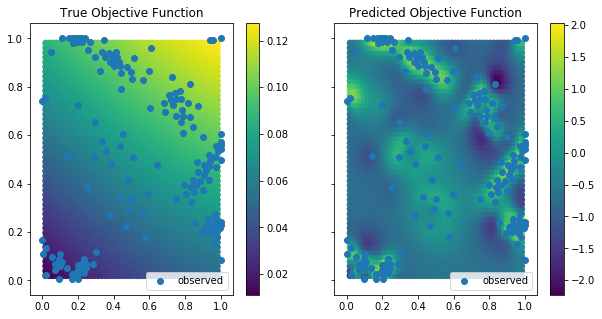

In [22]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
plt.sca(axes[0])
X = easy_meshgrid([50, 50], False)
Xscaled = bo.scale_to_bounds(X, [[-512, 512], [-512, 512]])
y = optimizer.descale_y(objective_function(Xscaled))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.colorbar()
# P = optimizer.model.covar_module.base_kernel.projection_module.weight.t()
# for i in range(d):
#     plt.plot([-P[0,i]/2+.5, P[0,i]/2+.5], [-P[1, i]/2+.5, P[1, i]/2+.5])
# plt.scatter([res.x[0, 0].numpy()],[res.x[0,1].numpy()])
plt.scatter(optimizer.obsX[:, 0], optimizer.obsX[:, 1], label='observed')
plt.legend()
plt.title('True Objective Function')

plt.sca(axes[1])
with torch.no_grad():
    pred_y = optimizer.model(X).mean
plt.scatter(X[:, 0], X[:, 1], c=pred_y)
plt.colorbar()
plt.scatter(optimizer.obsX[:, 0], optimizer.obsX[:, 1], label='observed')
plt.legend()
plt.title('Predicted Objective Function')
# plt.xlim(0, 1)
# plt.ylim(0, 1)

In [20]:
%matplotlib inline

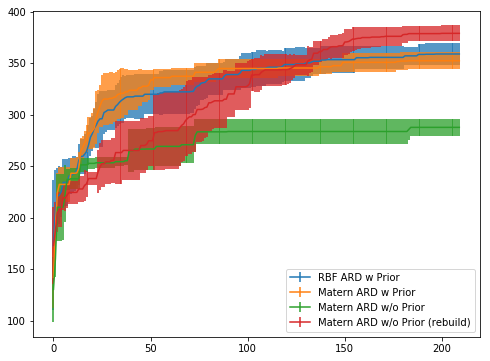

<Figure size 432x288 with 0 Axes>

In [44]:

import matplotlib.pyplot as plt
import numpy as np
import time
def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(NUM_TRIALS)

rbf_ard_history = np.array(rbf_ard_history)
matern_ard_history = np.array(matern_ard_history)
matern_no_prior_history = np.array(matern_no_prior_history)
matern_no_prior_history_fresh = np.array(matern_no_prior_history_fresh)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
iters = np.arange(rbf_ard_history.shape[-1])
ax.errorbar(iters, rbf_ard_history.mean(axis=0), yerr=ci(rbf_ard_history), label="RBF ARD w Prior", linewidth=1.5)
ax.errorbar(iters, matern_ard_history.mean(axis=0), yerr=ci(matern_ard_history), label="Matern ARD w Prior", linewidth=1.5)
ax.errorbar(iters, matern_no_prior_history.mean(axis=0), yerr=ci(matern_no_prior_history), label="Matern ARD w/o Prior", linewidth=1.5)
ax.errorbar(iters, matern_no_prior_history_fresh.mean(axis=0), yerr=ci(matern_no_prior_history_fresh),
            label="Matern ARD w/o Prior (rebuild)", linewidth=1.5)
plt.legend()
plt.show()
plt.savefig('./testing_stybtang_priors_sensitivity.png')